In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from modelval import pairptl, network, trainer, dataset
from modelval.ArbDataGen import arb_w_gen

% matplotlib inline
%load_ext autoreload
    
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [50]:
from modelval.network import BaseNet

In [51]:
test = BaseNet()

In [52]:
test.graph

AttributeError: 'BaseNet' object has no attribute 'graph'

In [53]:
test_net = Network()
test_net.build(10,1, lr=0.001)

In [32]:
test_var = tf.get_variable(name='test_var', shape=[1])

In [39]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    a = sess.run(test_var)

In [40]:
a

array([0.6768967], dtype=float32)

/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


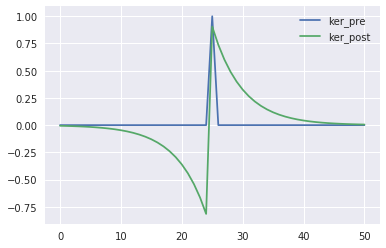

In [4]:
# Visualize kernel
from modelval.kernel import KernelGen
ker_test = KernelGen()
plt.plot(ker_test.dot_ker, label='ker_pre')
plt.plot(ker_test.bilat_ker, label='ker_post')
plt.legend()

In [7]:
# Create the network
ground_truth_init = 0
toy_data_net = network.PairNet(kernel=ker_test, kernel_pre=ker_test.dot_ker, kernel_post=ker_test.bilat_ker, ground_truth_init=ground_truth_init, n_input=60000)

In [9]:
save_dir= '/src/Plasticity_Ker/model/PairNet_ptl1_toy'
toy_net_trainer = trainer.Trainer(toy_data_net.loss, input_name=toy_data_net.inputs, target_name=toy_data_net.target, save_dir=save_dir, optimizer_config={'learning_rate': toy_data_net.lr})

In [10]:
toy_net_trainer.restore_best()

bias = -0.7135134339332581


/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


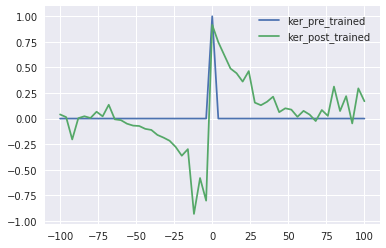

In [11]:
toy_net_trainer.restore_best()
w_pre = toy_net_trainer.evaluate(ops=toy_data_net.kernel_pre)
w_post = toy_net_trainer.evaluate(ops=toy_data_net.kernel_post)
plt.plot(np.linspace(0,100,51)*2 - 100, w_pre,  label='ker_pre_trained')
plt.plot(np.linspace(0,100,51)*2 - 100, w_post,  label='ker_post_trained')
bias = toy_net_trainer.evaluate(ops=toy_data_net.bias)
plt.legend()
print("bias = {bias}".format(bias=bias))